# Purposes of this document

the goal is to actually
examine the relevance of the features with respect to the estimated intentions.

we fit the est. intentions to the features(spike_counts) 
and test the p_values of the reg. coefficients. 

we expect to see:
1. for each row,  it should similar to the encoder C matrix
2. the non-relevant features or non-encoding features would have close to 1 p-values. 

in the end, 
we will demonstrate the mismatch through
1. the rewarded trials and the reward trial rate. 
2. qualitative comparisions of trajectories. 
3. the tuning directions of C. and the tracking performance using correlation coefficients

# Experimental setup related to the questions

this part should be configured to directly test the hypothesis put forward in the previous section


In [1]:
import numpy as np

#encoder mean firing rate
neuron_firing_rates  = [1, 10, 100]

#for comparision
exp_conds = [f'enc. mean FR:{b} s' for b in neuron_firing_rates]


#setting clda parameters 
##learner: collects paird data at batch_sizes
RHO = 0.5
batch_size = 10


#assistor set up assist level
assist_level = (0.05, 0.0)

#learner and updater: actualy set up rho
UPDATER_BATCH_TIME = 1
UPDATER_HALF_LIFE = np.log(RHO)  * UPDATER_BATCH_TIME / np.log(0.5)


In [2]:
# CHANGE: game mechanics: generate task params
N_TARGETS = 8
N_TRIALS = 8

NUM_EXP = len(exp_conds) # how many experiments we are running. 

# setting up the simulation components

this section largely copyied and pasted from   
bmi3d-sijia(branch)-bulti_in_experiemnts
https://github.com/sijia66/brain-python-interface/blob/master/built_in_tasks/sim_task_KF.py

In [3]:
# import libraries
# make sure these directories are in the python path., 
from bmimultitasks import SimBMIControlMulti, SimBMICosEncKFDec, BMIControlMultiNoWindow
from features import SaveHDF
from features.simulation_features import get_enc_setup, SimKFDecoderRandom, SimCosineTunedEnc,SimIntentionLQRController, SimClockTick
from features.simulation_features import SimHDF, SimTime

from riglib import experiment

from riglib.stereo_opengl.window import FakeWindow
from riglib.bmi import train

from weights import replace_kalman_filter
import weights

import time
import copy
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
import itertools #for identical sequences

np.set_printoptions(precision=2, suppress=True)


/home/sijia-aw/BMi3D_my/lab_bmi3d/riglib/blackrock/cerelink.py:13: UserWarning: Unable to import cerebus library. Check if is installed if using the Blackrock NeuroPort system
  warnings.warn("Unable to import cerebus library. Check if is installed if using the Blackrock NeuroPort system")


##  behaviour and task setup

In [4]:
seq = SimBMIControlMulti.sim_target_seq_generator_multi(
N_TARGETS, N_TRIALS)

#create a second version of the tasks
seqs = itertools.tee(seq, NUM_EXP + 1)
target_seq = list(seqs[NUM_EXP])

seqs = seqs[:NUM_EXP]


SAVE_HDF = False
SAVE_SIM_HDF = True #this makes the task data available as exp.task_data_hist
DEBUG_FEATURE = False


#base_class = SimBMIControlMulti
base_class = BMIControlMultiNoWindow

#for adding experimental features such as encoder, decoder
feats = []

## encoder

the cosine tuned encoder uses a poisson process, right
https://en.wikipedia.org/wiki/Poisson_distribution
so if the lambda is 1, then it's very likely 

In [5]:
ENCODER_TYPE = 'cosine_tuned_encoder'

#neuron set up : 'std (20 neurons)' or 'toy (4 neurons)' 
N_NEURONS, N_STATES, sim_C = get_enc_setup(sim_mode = 'toy')


#actually multiply out the firing rates. 
sim_C_all = [sim_C * nfr for nfr in neuron_firing_rates]


#set up intention feedbackcontroller
#this ideally set before the encoder
feats.append(SimIntentionLQRController)

#set up the encoder
if ENCODER_TYPE == 'cosine_tuned_encoder' :
    feats.append(SimCosineTunedEnc)
    print(f'{__name__}: selected SimCosineTunedEnc\n')

features.simulation_features: get_enc_setup has a tuning_level of 1 

__main__: selected SimCosineTunedEnc



## decoder setup

In [6]:
#clda on random 
DECODER_MODE = 'random' # random 

   #take care the decoder setup
if DECODER_MODE == 'random':
    feats.append(SimKFDecoderRandom)
    print(f'{__name__}: set base class ')
    print(f'{__name__}: selected SimKFDecoderRandom \n')
else: #defaul to a cosEnc and a pre-traind KF DEC
    from features.simulation_features import SimKFDecoderSup
    feats.append(SimKFDecoderSup)
    print(f'{__name__}: set decoder to SimKFDecoderSup\n')

__main__: set base class 
__main__: selected SimKFDecoderRandom 



##  clda: learner and updater

In [7]:


LEARNER_TYPE = 'feedback' # to dumb or not dumb it is a question 'feedback'
UPDATER_TYPE = 'smooth_batch' #none or "smooth_batch"


#you know what? 
#learner only collects firing rates labeled with estimated estimates
#we would also need to use the labeled data
#now, we can set up a dumb/or not-dumb learner
if LEARNER_TYPE == 'feedback':
    from features.simulation_features import SimFeedbackLearner
    feats.append(SimFeedbackLearner)
else:
    from features.simulation_features import SimDumbLearner
    feats.append(SimDumbLearner)

#to update the decoder.
if UPDATER_TYPE == 'smooth_batch':
    from features.simulation_features import SimSmoothBatch
    feats.append(SimSmoothBatch)
else: #defaut to none 
    print(f'{__name__}: need to specify an updater')
    



## assistor setup

## (Check) config the experiment

In [8]:
if DEBUG_FEATURE: 
    from features.simulation_features import DebugFeature
    feats.append(DebugFeature)
    
if SAVE_HDF: feats.append(SaveHDF)
if SAVE_SIM_HDF: feats.append(SimHDF)
    
    
#pass the real time limit on clock
feats.append(SimClockTick)
feats.append(SimTime)


kwargs_exps = list()

for i in range(NUM_EXP):
    d = dict()
    
    d['assist_level'] = assist_level
    d['sim_C'] = sim_C_all[i]
    d['batch_size'] = batch_size
    
    kwargs_exps.append(d)


kwargs_exps

[{'assist_level': (0.05, 0.0),
  'sim_C': array([[ 0.,  0.,  0.,  1.,  0.,  0.,  0.],
         [ 0.,  0.,  0., -1.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  1.,  0.],
         [ 0.,  0.,  0.,  0.,  0., -1.,  0.]]),
  'batch_size': 10},
 {'assist_level': (0.05, 0.0),
  'sim_C': array([[  0.,   0.,   0.,  10.,   0.,   0.,   0.],
         [  0.,   0.,   0., -10.,   0.,   0.,   0.],
         [  0.,   0.,   0.,   0.,   0.,  10.,   0.],
         [  0.,   0.,   0.,   0.,   0., -10.,   0.]]),
  'batch_size': 10},
 {'assist_level': (0.05, 0.0),
  'sim_C': array([[   0.,    0.,    0.,  100.,    0.,    0.,    0.],
         [   0.,    0.,    0., -100.,    0.,    0.,    0.],
         [   0.,    0.,    0.,    0.,    0.,  100.,    0.],
         [   0.,    0.,    0.,    0.,    0., -100.,    0.]]),
  'batch_size': 10}]

## make and initalize experiment instances

In [9]:
#seed the experiment
np.random.seed(0)

#spawn the task
Exp = experiment.make(base_class, feats=feats)

exps = list()#create a list of experiment

for i,s in enumerate(seqs):
    e = Exp(s, **kwargs_exps[i])
    exps.append(e)

#run the ini
for e in exps: e.init()

metaclass constructor
(<class 'features.simulation_features.SimIntentionLQRController'>, <class 'features.simulation_features.SimCosineTunedEnc'>, <class 'features.simulation_features.SimKFDecoderRandom'>, <class 'features.simulation_features.SimFeedbackLearner'>, <class 'features.simulation_features.SimSmoothBatch'>, <class 'features.simulation_features.SimHDF'>, <class 'features.simulation_features.SimClockTick'>, <class 'features.simulation_features.SimTime'>, <class 'bmimultitasks.BMIControlMultiNoWindow'>)
[<class 'features.simulation_features.SimIntentionLQRController'>, <class 'features.simulation_features.SimCosineTunedEnc'>, <class 'features.simulation_features.SimKFDecoderRandom'>, <class 'features.simulation_features.SimFeedbackLearner'>, <class 'features.simulation_features.SimSmoothBatch'>, <class 'features.simulation_features.SimHDF'>, <class 'features.simulation_features.SimClockTick'>, <class 'features.simulation_features.SimTime'>]

features.simulation_features.SimInte

# Pre-experiment check: check the Kalman filter before training

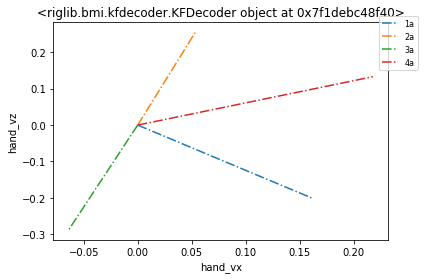

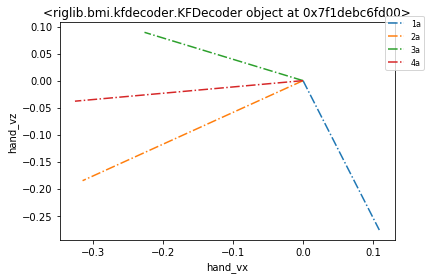

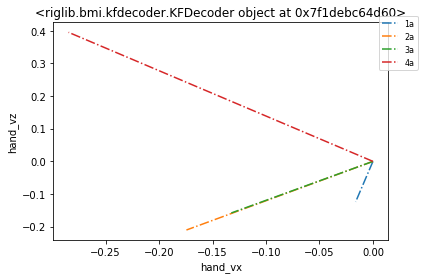

In [10]:
for e in exps:
    e.decoder.plot_K()

# Experiment run: assemble into a complete loop

##  define the function

In [11]:
#make this into a loop

def run_exp_loop(exp,  **kwargs):
        # riglib.experiment: line 597 - 601
    #exp.next_trial = next(exp.gen)
    # -+exp._parse_next_trial()np.arraynp.array


    # we need to set the initial state
    # per fsm.run:  line 138


    # Initialize the FSM before the loop
    exp.set_state(exp.state)
    
    finished_trials = exp.calc_state_occurrences('wait')
    print(f'finished: {finished_trials}')


    while exp.state is not None:

        # exp.fsm_tick()

        ### Execute commands#####
        exp.exec_state_specific_actions(exp.state)

        ###run the bmi loop #####
        # _cycle

        # bmi feature extraction, eh
        #riglib.bmi: 1202
        feature_data = exp.get_features()

        # Determine the target_state and save to file
        current_assist_level = exp.get_current_assist_level()
        target_state = exp.get_target_BMI_state(exp.decoder.states)

        # Determine the assistive control inputs to the Decoder
        #update assistive control level
        exp.update_level()
        if np.any(current_assist_level) > 0:
            current_state = exp.get_current_state()

            if target_state.shape[1] > 1:
                assist_kwargs = exp.assister(current_state, 
                                             target_state[:,0].reshape(-1,1), 
                                             current_assist_level, mode= exp.state)
            else:
                assist_kwargs = exp.assister(current_state, 
                                              target_state, 
                                              current_assist_level, 
                                              mode= exp.state)

            kwargs.update(assist_kwargs)
            
        

        # decode the new features
        # riglib.bmi.bmiloop: line 1245
        neural_features = feature_data[exp.extractor.feature_type]

        # call decoder.
        #tmp = exp.call_decoder(neural_features, target_state, **kwargs)
        neural_obs = neural_features
        learn_flag = exp.learn_flag
        task_state = exp.state

        n_units, n_obs = neural_obs.shape
        # If the target is specified as a 1D position, tile to match
        # the number of dimensions as the neural features
        if np.ndim(target_state) == 1 or (target_state.shape[1] == 1 and n_obs > 1):
            target_state = np.tile(target_state, [1, n_obs])

        decoded_states = np.zeros([exp.bmi_system.decoder.n_states, n_obs])
        update_flag = False

        for k in range(n_obs):
            neural_obs_k = neural_obs[:, k].reshape(-1, 1)
            target_state_k = target_state[:, k]

            # NOTE: the conditional below is *only* for compatibility with older Carmena
            # lab data collected using a different MATLAB-based system. In all python cases,
            # the task_state should never contain NaN values.
            if np.any(np.isnan(target_state_k)):
                task_state = 'no_target'

            #################################
            # Decode the current observation
            #################################
            decodable_obs, decode = exp.bmi_system.feature_accumulator(
                neural_obs_k)
            if decode:  # if a new decodable observation is available from the feature accumulator
                prev_state = exp.bmi_system.decoder.get_state()

                exp.bmi_system.decoder(decodable_obs, **kwargs)
                # Determine whether the current state or previous state should be given to the learner
                if exp.bmi_system.learner.input_state_index == 0:
                    learner_state = exp.bmi_system.decoder.get_state()
                elif exp.bmi_system.learner.input_state_index == -1:
                    learner_state = prev_state
                else:
                    print(("Not implemented yet: %d" %
                           exp.bmi_system.learner.input_state_index))
                    learner_state = prev_state

                if learn_flag:
                    exp.bmi_system.learner(decodable_obs.copy(), learner_state, target_state_k, exp.bmi_system.decoder.get_state(
                    ), task_state, state_order=exp.bmi_system.decoder.ssm.state_order)

            decoded_states[:, k] = exp.bmi_system.decoder.get_state()

            ############################
            # Update decoder parameters
            ############################
            if exp.bmi_system.learner.is_ready():
                batch_data = exp.bmi_system.learner.get_batch()
                batch_data['decoder'] = exp.bmi_system.decoder
                kwargs.update(batch_data)
                exp.bmi_system.updater(**kwargs)
                exp.bmi_system.learner.disable()

            new_params = None  # by default, no new parameters are available
            if exp.bmi_system.has_updater:
                new_params = copy.deepcopy(exp.bmi_system.updater.get_result())

            # Update the decoder if new parameters are available
            if not (new_params is None):
                exp.bmi_system.decoder.update_params(
                    new_params, **exp.bmi_system.updater.update_kwargs)
                new_params['intended_kin'] = batch_data['intended_kin']
                new_params['spike_counts_batch'] = batch_data['spike_counts']

                exp.bmi_system.learner.enable()
                update_flag = True

                # Save new parameters to parameter history
                exp.bmi_system.param_hist.append(new_params)



        # saved as task data
        # return decoded_states, update_flag
        tmp = decoded_states
        exp.task_data['internal_decoder_state'] = tmp

        # reset the plant position
        # @riglib.bmi.BMILoop.move_plant  line:1254
        exp.plant.drive(exp.decoder)

        # check state transitions and run the FSM.
        current_state = exp.state

        # iterate over the possible events which could move the task out of the current state
        for event in exp.status[current_state]:
            # if the event has occurred
            if exp.test_state_transition_event(event):
                # execute commands to end the current state
                exp.end_state(current_state)

                # trigger the transition for the event
                exp.trigger_event(event)

                # stop searching for transition events (transition events must be
                # mutually exclusive for this FSM to function properly)
                break

        # sort out the loop params.
        # inc cycle count
        exp.cycle_count += 1

        # save target data as was done in manualControlTasks._cycle
        exp.task_data['target'] = exp.target_location.copy()
        exp.task_data['target_index'] = exp.target_index

        #done in bmi:_cycle after move_plant
        exp.task_data['loop_time'] = exp.iter_time()


        #fb_controller data
        exp.task_data['target_state'] = target_state

        #encoder data
        #input to this is actually extractor
        exp.task_data['ctrl_input'] = np.reshape(exp.extractor.sim_ctrl, (1,-1))

        #actually output
        exp.task_data['spike_counts'] = feature_data['spike_counts']


        #save the decoder_state
        #from BMILoop.move_plant
        exp.task_data['decoder_state'] = exp.decoder.get_state(shape=(-1,1))
        
        #save bmi_data
        exp.task_data['update_bmi'] = update_flag


        # as well as plant data.
        plant_data = exp.plant.get_data_to_save()
        for key in plant_data:
            exp.task_data[key] = plant_data[key]

        # clda data handled in the above call.

        # save to the list hisory of data.
        exp.task_data_hist.append(exp.task_data.copy())
        
        #print out the trial update whenever wait count changes, alright. 
        if finished_trials != exp.calc_state_occurrences('wait'):
            finished_trials = exp.calc_state_occurrences('wait')
            print(f'finished trials :{finished_trials} with a current assist level of {exp.get_current_assist_level()}')


    if exp.verbose:
        print("end of FSM.run, task state is", exp.state)
    
    


## actually running the experiments

In [12]:
for i,e in enumerate(exps):
    run_exp_loop(e, **kwargs_exps[i])
    print(f'Finished running  {exp_conds[i]}')

runseq
finished: 1
assist_level:  0.05


/home/sijia-aw/BMi3D_my/lab_bmi3d/riglib/bmi/kfdecoder.py:372: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  C = np.mat(np.linalg.lstsq(X.T, Y.T)[0].T)


assist_level:  0.045
finished trials :2 with a current assist level of 0.04077083333333334
assist_level:  0.04
assist_level:  0.035
finished trials :3 with a current assist level of 0.03156111111111111
assist_level:  0.03
assist_level:  0.025
finished trials :4 with a current assist level of 0.022351388888888893
assist_level:  0.020000000000000004
assist_level:  0.015000000000000006
finished trials :5 with a current assist level of 0.01314166666666667
assist_level:  0.009999999999999995
assist_level:  0.0049999999999999975
finished trials :6 with a current assist level of 0.003931944444444453
assist_level at final value after 0 successful trials
finished trials :7 with a current assist level of 0.0
finished trials :8 with a current assist level of 0.0
finished trials :9 with a current assist level of 0.0
end of FSM.run, task state is None
Finished running  enc. mean FR:1 s
runseq
finished: 1
finished trials :2 with a current assist level of 0.04800694444444445
finished trials :3 with a

# Postprocessing the data for loading

In [13]:
for e in  exps: print(e.calc_state_occurrences('reward'))

0
8
7


## declare defs and conventions

In [14]:
FRAME_RATE = 60
INT_WINDOW_TIME = 10 # s for looking at sample raw data

# some conventions as we go down the loop
X_VEL_STATE_IND = 3
Y_VEL_STATE_IND = 5
X_POS_STATE_IND = 0
Y_POS_STATE_IND = 2

state_indices = [X_POS_STATE_IND,
                 Y_POS_STATE_IND,
                 X_VEL_STATE_IND,
                 Y_VEL_STATE_IND]
state_names = ['x pos ', 'y pos', 'x vel', 'y vel']


INT_WIN_SAMPLES = INT_WINDOW_TIME * FRAME_RATE



## Refactor out the data

In [15]:
task_data_hist_np_all = [np.array(e.task_data_hist) for e in exps]
len(task_data_hist_np_all)
task_data_hist_np_all[0].dtype

dtype([('cursor', '<f8', (3,)), ('obs_t', '<f8', (4, 1)), ('K', '<f8', (7, 4)), ('KC', '<f8', (7, 7)), ('pred_state_mean', '<f8', (7, 1)), ('post_state_mean', '<f8', (7, 1)), ('pred_state_P', '<f8', (7, 7)), ('post_state_P', '<f8', (7, 7)), ('loop_time', '<f8', (1,)), ('decoder_state', '<f8', (7, 1)), ('internal_decoder_state', '<f8', (7, 1)), ('target_state', '<f8', (7, 1)), ('update_bmi', '<f8', (1,)), ('spike_counts', '<f8', (4, 1)), ('bin_edges', '<f8', (2,)), ('ctrl_input', '<f8', (7,)), ('assist_level', '<f8', (1,)), ('target', '<f8', (3,)), ('target_index', '<i4', (1,))])

# Post data analysis

## Overall  trial statistics succuss rate)

In [16]:
def filter_state(state_log:list, state_to_match:str)->list:
    '''#set axis limits of plot (x=0 to 20, y=0 to 20)
plt.axis([0, 20, 0, 20])
plt.axis("equal")

    state_log: a list of tuples (state:string, start_time: float)
    state_to_watch
    
    returns a list of element type
    '''
    
    return list(filter(lambda k: k[0] == state_to_match, state_log) )

def calc_inter_wait_times(wait_log: list)-> list:
    """
    state_log: a list of tuples ("wait", start_time: float)
    return a list of tuples: ("wait", start_time: float, diff_time)
    """
    wait_log_with_diff = list()
    for i, wait_state in enumerate(wait_log):
        if i == len(wait_log)-1: #there is nothing to subtract, just put zero.
            wait_log_with_diff.append((wait_state[1],  0))
            
        else:
            finish_time = wait_log[i+1][1]
            wait_log_with_diff.append((wait_state[1],  finish_time - wait_state[1]))
    
    return np.array(wait_log_with_diff[:-1])

In [17]:
state_logs = [e.state_log for e in exps]


In [18]:
STATE_CUT_NAME =  'wait'
#get the state logs
wait_logs = [filter_state(s, STATE_CUT_NAME) for s in state_logs]

inter_wait_times = [calc_inter_wait_times(w) for w in wait_logs]
#this has both start times 

Text(0, 0.5, 'Trial time (s)')

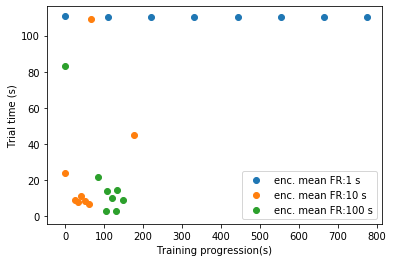

In [19]:


for i in inter_wait_times:
    plt.scatter(i[:,0], i[:,1])

plt.legend(exp_conds)
plt.xlabel('Training progression(s)')
plt.ylabel('Trial time (s)')

In [20]:
wait_time = inter_wait_times[0]
task_data_hist_np = task_data_hist_np_all[0]



In [21]:
def sort_trials(wait_time:list, 
                target_seq:list,
                task_data_hist_np:dict, 
                dict_keys, FRAME_RATE = 60):
    trial_dict = list()
    
    for i,row in enumerate(wait_time):
        start_time = row[0]
        inter_wait_time = row[1]

        start_sample = int(start_time * FRAME_RATE)
        inter_wait_sample = int(inter_wait_time * FRAME_RATE)
        stop_sample = start_sample + inter_wait_sample

        single_trial_dict = dict()

        for k in dict_keys:
            
            requested_type_data = np.squeeze(task_data_hist_np[k])
            single_trial_dict[k] =  requested_type_data[start_sample:stop_sample,
                                                       :]
        #add more info
        single_trial_dict['start_time'] = row[0]
        single_trial_dict['inter_wait_time'] = row[1]
        
        #add target info
        single_trial_dict['targets'] = target_seq[i]

        #add the dictionary to the list
        trial_dict.append(single_trial_dict)
        
    return trial_dict



In [22]:


trial_dicts_all = []
dict_keys = ['cursor', #behaviour
             'ctrl_input', 'spike_counts', #encoder translates intended ctrl into spike counts
             'decoder_state']

for i in range(NUM_EXP):
    wait_time = inter_wait_times[i]
    task_data_hist_np = task_data_hist_np_all[i]
    
    trial_dict_0 = sort_trials(wait_time, 
                               target_seq,
                               task_data_hist_np, dict_keys)
    
    trial_dicts_all.append(trial_dict_0)

len(trial_dicts_all)

3

## Trajectory analysis

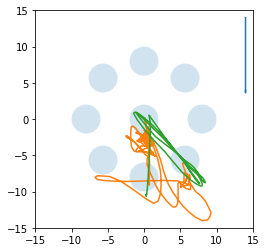

In [23]:
n_roi_trials = N_TRIALS - 1
unique_targets =  np.unique(target_seq, axis = 0)


X_CURSOR = 0
Z_CURSOR = 2
CIRCL_ALPHA = 0.2



RANGE_LIM =  15
figure, axes = plt.subplots() 

axes.set_xlim(-RANGE_LIM, RANGE_LIM)
axes.set_ylim(-RANGE_LIM, RANGE_LIM)

CIRCLE_RADIUS = exps[0].target_radius

#plot the targets

#plot the origin

cc = plt.Circle((0,0 ), 
            radius = CIRCLE_RADIUS,
            alpha = CIRCL_ALPHA)

axes.add_artist( cc ) 

for origin_t in unique_targets:
    origin = origin_t[0]
    t = origin_t[1]

    cc = plt.Circle((t[X_CURSOR],t[Z_CURSOR] ), 
                    radius = CIRCLE_RADIUS,
                    alpha = CIRCL_ALPHA)
                     
    axes.set_aspect( 1 ) 
    axes.add_artist( cc ) 
    
    
for trial_dict in trial_dicts_all:
    
    sample_trial = trial_dict[n_roi_trials]
    trial_cursor_trajectory = sample_trial['cursor']
    
    
    axes.plot(trial_cursor_trajectory[:, X_CURSOR], 
             trial_cursor_trajectory[:, Z_CURSOR])
    N_TRIALS = 80



In [24]:
print('finished trials:')

for i,e in  enumerate(exps): 
    reward_num = e.calc_state_occurrences('reward')
    print(f'{exp_conds[i]}: {reward_num} out of {N_TRIALS}')

finished trials:
enc. mean FR:1 s: 0 out of 80
enc. mean FR:10 s: 8 out of 80
enc. mean FR:100 s: 7 out of 80


## encoder

the job of the encoder is to directly encode intention into firing rates
the direct measure is just pearson correlation coefficients between 
the intentions and the firing rates

In [25]:
print('the encoder observation Q matrix')
for i,e in enumerate(exps):
    print(exp_conds[i])
    print(e.encoder.ssm.w)

the encoder observation Q matrix
enc. mean FR:1 s
7
enc. mean FR:10 s
7
enc. mean FR:100 s
7


In [26]:
n_exp = 0


spike_count_sample = trial_dicts_all[n_exp][n_roi_trials]['spike_counts']

## decoder

steady state tuning curves:


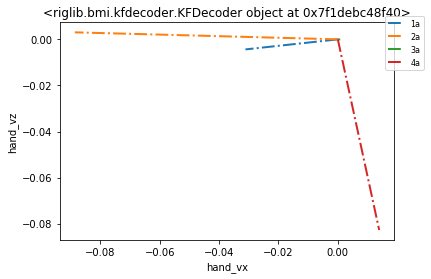

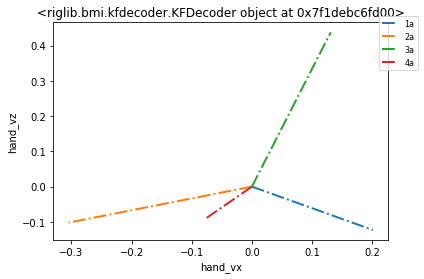

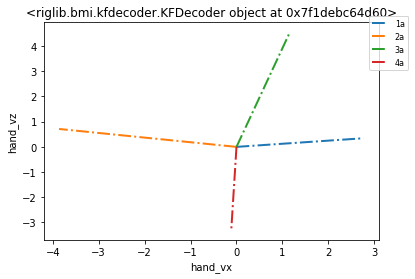

In [27]:
print('steady state tuning curves:')

for i,e in enumerate(exps):
    e.decoder.plot_C()

# CLDA updates

## clda update frequencies

In [28]:

clda_params_all = [np.array(e.bmi_system.param_hist) for e in exps]

for c in clda_params_all:
    print(f'did clda for {len(c)} times')

did clda for 884 times
did clda for 220 times
did clda for 157 times


In [29]:
update_bmi_all = np.squeeze(task_data_hist_np_all[0]['update_bmi'])

Text(0.5, 0, 'frame count')

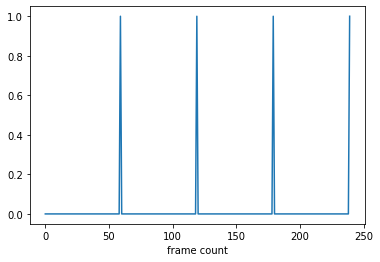

In [30]:
plt.plot(update_bmi_all[:240])
plt.xlabel('frame count')

## reformat the matrix

In [31]:
clda_params = clda_params_all[1]

clda_params_dict_all = list()

for p in clda_params_all:
    clda_params_dict = dict()
    for param_key in p[0].keys():
        clda_params_dict[param_key] = np.array([ record_i[param_key] for record_i in p])
    
    clda_params_dict_all.append(clda_params_dict)


len(clda_params_dict_all)

3

## observation covariance matrix

In [32]:
n_sample = 1

for i,c in enumerate(clda_params_dict_all):
    print(exp_conds[i])
    print(c['kf.Q'][n_sample,:,:])
    print()

enc. mean FR:1 s
[[9.79 0.   0.   0.  ]
 [0.   9.77 0.   0.  ]
 [0.   0.   9.77 0.  ]
 [0.   0.   0.   9.77]]

enc. mean FR:10 s
[[ 9.92 -0.01 -0.    0.01]
 [-0.01  9.77  0.   -0.  ]
 [-0.    0.    9.79  0.  ]
 [ 0.01 -0.    0.    9.77]]

enc. mean FR:100 s
[[13.97 -0.29 -0.03  0.4 ]
 [-0.29  9.83 -0.04 -0.07]
 [-0.03 -0.04 10.73  0.79]
 [ 0.4  -0.07  0.79 10.66]]



## clda K matrix

In [33]:
kf_C = clda_params_dict['kf.C']

In [34]:
print('K matrix before:')
print(kf_C[0,:,:])
print('K matrix after:')
print(kf_C[-1,:,:])

K matrix before:
[[ 0.    0.    0.   -0.27  0.   -0.37 -0.78]
 [ 0.    0.    0.   -1.62  0.   -0.9   0.09]
 [ 0.    0.    0.   -1.22  0.   -0.63 -0.84]
 [ 0.    0.    0.   -1.15  0.    0.38 -1.47]]
K matrix after:
[[ 0.    0.    0.    2.76  0.    0.34 18.76]
 [ 0.    0.    0.   -3.86  0.    0.71 22.85]
 [ 0.    0.    0.    1.16  0.    4.55 35.86]
 [ 0.    0.    0.   -0.11  0.   -3.3  28.65]]


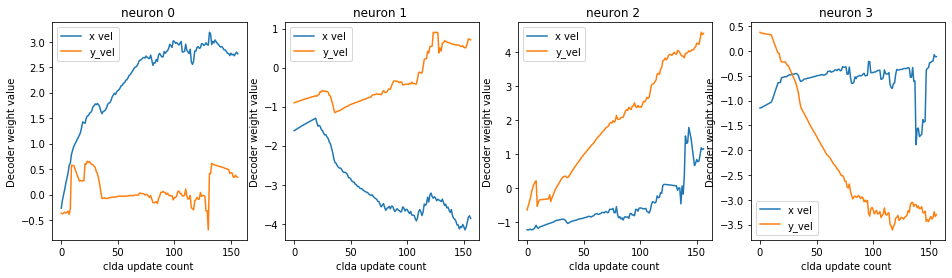

In [35]:
N_CLDA_ROI_TIME = 800

FIGURE_SIZE = (2,10)

N_NEURONS

f, axs = plt.subplots(1,N_NEURONS,figsize=(16,4))

for i in range(N_NEURONS):
    axs[i].plot(np.squeeze(kf_C[:N_CLDA_ROI_TIME,i, X_VEL_STATE_IND]))
    axs[i].plot(np.squeeze(kf_C[:N_CLDA_ROI_TIME,i, Y_VEL_STATE_IND]))
    axs[i].legend(['x vel', 'y_vel'])
    axs[i].set_title(f'neuron {i} ')
    axs[i].set_xlabel('clda update count ')
    axs[i].set_ylabel('Decoder weight value')



In [36]:
exps[0].encoder.C

array([[ 0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0., -1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  0., -1.,  0.]])

## examine training batches

In [37]:
spike_counts_batch = clda_params_dict['spike_counts_batch'] 
intended_kin = clda_params_dict['intended_kin']

In [38]:
training_sample_point = 2

print('intended kinematics:')
print(intended_kin[training_sample_point])

print('spike counts:')
print(spike_counts_batch[training_sample_point])

print('trained KF C matrix:')
print(kf_C[training_sample_point])

intended kinematics:
[[ -4.25  -5.76  -7.33  -8.62  -9.98 -11.43 -12.64 -13.78 -14.75 -14.  ]
 [  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.  ]
 [-14.   -14.   -14.   -14.   -14.   -14.   -14.   -14.   -14.   -14.  ]
 [  2.22   1.44   2.36   4.43   4.85   5.61   7.89   8.99  10.47  18.92]
 [  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.  ]
 [ 12.04  12.04  12.04  12.04  12.04  12.04  12.04  12.04  12.04  12.04]
 [  1.     1.     1.     1.     1.     1.     1.     1.     1.     1.  ]]
spike counts:
[[ 22.   9.  34.  55.  52.  49.  74.  88. 104. 177.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [121. 119. 111. 128. 132. 114. 121. 116. 119. 121.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]]
trained KF C matrix:
[[ 0.    0.    0.   -0.    0.   -0.37 -1.03]
 [ 0.    0.    0.   -1.58  0.   -0.88  0.08]
 [ 0.    0.    0.   -1.2   0.   -0.4  -0.53]
 [ 0.    0.    0.   -1.13  0.    0.36 -1.23]]


# feature analyses

In [42]:
import statsmodels.api as sm


## Examine relevance of one neuron from one batch 

### Select data

In [43]:
clda_params_dict.keys() # this is from one experiment

dict_keys(['kf.C', 'kf.Q', 'kf.C_xpose_Q_inv_C', 'kf.C_xpose_Q_inv', 'mFR', 'sdFR', 'rho', 'intended_kin', 'spike_counts_batch'])

In [47]:
spike_counts_batch = clda_params_dict['spike_counts_batch']
intended_kin = clda_params_dict['intended_kin']
print(f'{len(spike_counts_batch)}')
print(f'{len(intended_kin)}')

157
157


In [50]:
# we just take one batch
batch_of_interest = 0
spike_count_one_batch = spike_counts_batch[batch_of_interest]
intended_kin_one_batch = intended_kin[batch_of_interest]

print(f'look at one batch: batch number {batch_of_interest}')
print(f'spike count')
print(spike_count_one_batch)

print(f'intended kin')
print(intended_kin_one_batch)

look at one batch: batch number 0
spike count
[[ 0.  0.  0. 62. 68. 19. 53. 59. 66. 65.]
 [ 0.  7.  5.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. 19.  0.  0.  0.  9.]
 [ 0.  0.  2.  0. 38.  0. 10.  7. 22.  0.]]
intended kin
[[ 0.   -0.05 -0.24 -0.42 -0.43 -1.92 -2.19 -2.59 -2.86 -3.73]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.03 -0.09 -0.05 -1.11  0.13 -0.5  -0.76 -1.35 -1.08]
 [ 0.   -0.24  6.02  6.14  6.34  1.89  5.69  6.47  7.22  5.7 ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.13 -0.45  0.01 -3.06  2.46 -0.83 -0.76 -1.44  0.7 ]
 [ 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.  ]]


In [57]:
print('we are dealing with a velocity decoder')
print('we only look at  x vel and y vel:')
print('We assume we are only interested how firing rates encode x, y vel')

intended_kin_one_batch_2D = intended_kin_one_batch[(X_VEL_STATE_IND, Y_VEL_STATE_IND),:]
print('after selecting the vels:')
print(intended_kin_one_batch_2D)

we are dealing with a velocity decoder
we only look at  x vel and y vel:
We assume we are only interested how firing rates encode x, y vel
after selecting the vels:
[[ 0.   -0.24  6.02  6.14  6.34  1.89  5.69  6.47  7.22  5.7 ]
 [ 0.    0.13 -0.45  0.01 -3.06  2.46 -0.83 -0.76 -1.44  0.7 ]]


In [58]:
print('we will do  one neuron at a time')
n_roi_neuron = 0
print(f'the neuron that we are interested is neuron {n_roi_neuron}')
print('and selected firing rates:')

spike_count_one_batch_one_neuron = spike_count_one_batch[n_roi_neuron,:]

print(spike_count_one_batch_one_neuron)

we will do  one neuron at a time
the neuron that we are interested is neuron 0
and selected firing rates:
[ 0.  0.  0. 62. 68. 19. 53. 59. 66. 65.]


### OLS model fitting

In [189]:
print('we transpose the vector for fitting')
X = intended_kin_one_batch_2D.T
y = np.reshape(spike_count_one_batch_one_neuron, (-1,1))


print('the independent variables are  the intended kin hence, X')
print(X)


print('the dependent variable is the neuron spike connt, hence y')
print(y)


we transpose the vector for fitting
the independent variables are  the intended kin hence, X
[[ 12.04 -12.04]
 [ 12.04 -12.04]
 [ 12.04 -12.04]
 [ 12.04 -12.04]
 [ 12.04 -12.04]
 [ 12.04 -12.04]
 [ 12.04 -12.04]
 [ 12.04 -12.04]
 [ 12.04 -12.04]
 [ 12.04 -12.04]]
the dependent variable is the neuron spike connt, hence y
[[ 22.]
 [  9.]
 [ 34.]
 [ 55.]
 [ 52.]
 [ 49.]
 [ 74.]
 [ 88.]
 [104.]
 [177.]]


In [197]:
print('we add the constant one to the states (X)')
X = sm.add_constant(X, has_constant= 'raise')
print('the new X is')
print(X)

we add the constant one to the states (X)


ValueError: data already contains a constant

In [193]:
print('now we can fit using statsmodels.ols')

ols_spike_from_states = sm.OLS(y, X)

results_ols_spike_from_states = ols_spike_from_states.fit()

print('print results')
print(results_ols_spike_from_states.summary())

now we can fit using statsmodels.ols
print results
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Tue, 23 Feb 2021   Prob (F-statistic):                nan
Time:                        19:09:31   Log-Likelihood:                -52.468
No. Observations:                  10   AIC:                             106.9
Df Residuals:                       9   BIC:                             107.2
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c

/home/sijia-aw/BMi3D_my/lib/python3.8/site-packages/scipy/stats/stats.py:1534: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/sijia-aw/BMi3D_my/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1657: RuntimeWarning: invalid value encountered in double_scalars
  return self.ess/self.df_model


In [87]:
print('the p-values test against if the coefficients are zero')
neuron_batch_pvalue = results_ols_spike_from_states.pvalues

print(f'the p values for this neuron of index {n_roi_neuron}')
print(neuron_batch_pvalue)

neuron_batch_coeff = results_ols_spike_from_states.params

print('the reg. coeff. are ')
print(neuron_batch_coeff)

print()
significance_level = 0.05
print(f'at a significance_level of {significance_level}:')
print('this array has the indix of the states that are significantly correlated with the firing rates  ')

np.where(neuron_batch_pvalue < significance_level)

the p-values test against if the coefficients are zero
the p values for this neuron of index 0
[0.89 0.03 0.86]
the reg. coeff. are 
[ 2.14  8.12 -1.05]

at a significance_level of 0.05:
this array has the indix of the states that are significantly correlated with the firing rate 


(array([1]),)

## iterate up the model testing procedure

In [127]:
print('we write a function that actually  check if any given neuron has a sig state')


def get_significant_index(p_value_array: np.array, 
                          significance_level = 0.05, 
                         compare_mode = 'smaller_or_equal'):
    '''
    compare each element in the p_value_list against signifance level. 
    mode defaults to smaller_than for comparing p_value
    '''
    
    if compare_mode == 'smaller_or_equal': 
        sig_test_list = np.where(p_value_array <= significance_level)
        sig_test_list = np.array(np.squeeze(sig_test_list))
        return sig_test_list
    elif compare_mode == 'larger_or_equal':
        return np.where(p_value_array >= significance_level)
    elif compare_mode == 'equal':
        return np.where(p_value_array == significance_level)
    else:
        raise Exception(f'unknown mode {compare_mode}')
        

def is_any_pvalue_significant(p_value_array: np.array, 
                              significance_level = 0.05,
                              compare_mode = 'smaller_or_equal'):
    """
    given the p_value_array
    check if any of the element is smaller than the significance_level (default to 0.05)
    """
    sig_test_list = get_significant_index(p_value_array,
                                           significance_level,
                                           compare_mode)
    
    
    return not (len(sig_test_list) == 0)





we write a function that actually  check if any given neuron has a sig state


In [93]:
print('with the functions, we can fit and test the one neuron and against the state')

with the functions, we can fit and test the one neuron and against the state


In [198]:
significance_level = 0.05

def have_same_num_rows(x: np.array, y:np.array):
    """
    check if x and y have the same number of rows
    """
    y_num_rows = x.shape[0]
    x_num_rows = y.shape[0]
    return y_num_rows == x_num_rows
    
    
def fit_ols(y, X, 
            significance_level = 0.05,
           add_constant_term_flag = True,
           force_add_constant = True):
    """
    fit  X to y in the ordinary least square sense
    in pre-conditioning, if add_constant_term_flag == True, returns 
    
    and returns  a tuple  of (neuron_batch_coeff, neuron_batch_pvalue, 
                                sig_flag, sig_p_value_indices)
    """
    #pre-fit: check the same number of rows
    if not have_same_num_rows(y, X): 
            raise Exception(f'y and X do not have the same number of rows') 

    #pre-fit: add the constant one to the states (X)'
    if  add_constant_term_flag: 
        if force_add_constant:
            X = sm.add_constant(X, has_constant='add')
        else:
            X = sm.add_constant(X, has_constant='raise')

    #fit using statsmodels.ols')
    ols_spike_from_states = sm.OLS(y, X)
    results_ols_spike_from_states = ols_spike_from_states.fit()

    #post-fit: get the coefficients
    neuron_batch_coeff = results_ols_spike_from_states.params
    #('the p-values test against if the coefficients are zero')
    neuron_batch_pvalue = results_ols_spike_from_states.pvalues

    sig_p_value_indices = np.array(get_significant_index(neuron_batch_pvalue,
                                                significance_level = significance_level))

    #return if any of the indix is empty
    sig_flag = not (sig_p_value_indices.size == 0)

    return (neuron_batch_coeff, 
           neuron_batch_pvalue,
           sig_flag,
           sig_p_value_indices)



In [185]:
print('we transpose the vector for fitting')
X = intended_kin_one_batch_2D.T
y = np.reshape(spike_count_one_batch_one_neuron, (-1,1))


print('the independent variables are  the intended kin hence, X')
print(X)


print('the dependent variable is the neuron spike connt, hence y')
print(y)

results = fit_ols(y, X)

print('fitting_results:')
print(results)


we transpose the vector for fitting
the independent variables are  the intended kin hence, X
[[ 12.04 -12.04]
 [ 12.04 -12.04]
 [ 12.04 -12.04]
 [ 12.04 -12.04]
 [ 12.04 -12.04]
 [ 12.04 -12.04]
 [ 12.04 -12.04]
 [ 12.04 -12.04]
 [ 12.04 -12.04]
 [ 12.04 -12.04]]
the dependent variable is the neuron spike connt, hence y
[[ 22.]
 [  9.]
 [ 34.]
 [ 55.]
 [ 52.]
 [ 49.]
 [ 74.]
 [ 88.]
 [104.]
 [177.]]
fitting_results:
(array([ 2.76, -2.76]), array([0., 0.]), True, array([0, 1]))


## test across the neurons in a batch

In [196]:
n_roi_neuron = 0

#assume spike_count_one_batch has the shape N_NEURONS by N_time points
#assume that intended_kin_one_batch_2D has N_states by N_Time_points


#get intended kinematics this is fixed for each neuron
intended_kin_one_batch_2D = intended_kin_one_batch[(X_VEL_STATE_IND, Y_VEL_STATE_IND),:]
#('we transpose the vector for fitting')
X = intended_kin_one_batch_2D.T

#pre-initialize to speed up
#after the transpose, we look at how many columns
N_Neurons = spike_count_one_batch.shape[0]
N_STATES = X.shape[1] + 1 # add 1 for the intersept

neuron_batch_pvalue_matrix = np.empty((N_Neurons, N_STATES))
neuron_batch_pvalue_matrix[:] = np.NaN #set all values to NaN

for n_roi_neuron in range(N_Neurons):

    #('selected firing rates:')
    spike_count_one_batch_one_neuron = spike_count_one_batch[n_roi_neuron,:]
    y = np.reshape(spike_count_one_batch_one_neuron, (-1,1)) #transpose

    (neuron_batch_coeff, neuron_batch_pvalue, sig_flag, sig_p_value_indices) = fit_ols(y, X)
    
    print(neuron_batch_pvalue)
    neuron_batch_pvalue_matrix[n_roi_neuron,:] = neuron_batch_pvalue

print(f'the pvalue matrix for a batch')
neuron_batch_pvalue_matrix

[0. 0. 0.]
[nan nan nan]
[nan nan nan]
[0. 0. 0.]
the pvalue matrix for a batch


/home/sijia-aw/BMi3D_my/lib/python3.8/site-packages/statsmodels/base/model.py:1294: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/home/sijia-aw/BMi3D_my/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/sijia-aw/BMi3D_my/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/sijia-aw/BMi3D_my/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
<ipython-input-127-4e8d2504454f>:13: RuntimeWarning: invalid value encountered in less_equal
  sig_test_list = np.where(p_value_array <= significance_level)


array([[ 0.,  0.,  0.],
       [nan, nan, nan],
       [nan, nan, nan],
       [ 0.,  0.,  0.]])

In [201]:
# we are gonna package this in a batch

def calculate_p_value_matrix(intended_kin_one_batch_2D:np.array, 
                            spike_count_one_batch:np.array):
    """
    this function iteratively fits an ols of the states to the firing rates 
    spike_count_one_batch = reg_coeff * intended_kin_one_batch_2D + error
    and returns a neuron_batch_pvalue_matrix of N_NEURONS by (N_STATES + 1) 
    
    inputs:
    intended_kin_one_batch_2D: N_NEURONS by N_TIME_POINTS
    spike_count_one_batch: N_STATES by N_TIME_POINTS
    
    output:
    neuron_batch_pvalue_matrix: N_NEURONS by (N_STATES + 1) 
    """

    X = intended_kin_one_batch_2D.T

    #pre-initialize to speed up
    #after the transpose, we look at how many columns
    N_Neurons = spike_count_one_batch.shape[0]
    N_STATES = X.shape[1] + 1 # add 1 for the intersept

    neuron_batch_pvalue_matrix = np.empty((N_Neurons, N_STATES))
    neuron_batch_pvalue_matrix[:] = np.NaN #set all values to NaN

    for n_roi_neuron in range(N_Neurons):

        #('selected firing rates:')
        spike_count_one_batch_one_neuron = spike_count_one_batch[n_roi_neuron,:]
        y = np.reshape(spike_count_one_batch_one_neuron, (-1,1)) #transpose
        
        (neuron_batch_coeff, neuron_batch_pvalue, sig_flag, sig_p_value_indices) = fit_ols(y, X)
        neuron_batch_pvalue_matrix[n_roi_neuron,:] = neuron_batch_pvalue
        
    return neuron_batch_pvalue_matrix

print('test out the calculate_p_value_matrix')

calc_p_value_matrix_result = calculate_p_value_matrix(intended_kin_one_batch_2D, 
                            spike_count_one_batch)
print(calc_p_value_matrix_result)
print()
print('for comparision, this is what we just calculated')
neuron_batch_pvalue_matrix

test out the calculate_p_value_matrix
[[ 0.  0.  0.]
 [nan nan nan]
 [nan nan nan]
 [ 0.  0.  0.]]

for comparision, this is what we just calculated


<ipython-input-127-4e8d2504454f>:13: RuntimeWarning: invalid value encountered in less_equal
  sig_test_list = np.where(p_value_array <= significance_level)


array([[ 0.,  0.,  0.],
       [nan, nan, nan],
       [nan, nan, nan],
       [ 0.,  0.,  0.]])

## calculate p_values for a different batch

In [204]:
# we just take one batch
batch_of_interest = 12

intended_kin_one_batch = intended_kin[batch_of_interest]
intended_kin_one_batch_2D = intended_kin_one_batch[(X_VEL_STATE_IND, Y_VEL_STATE_IND),:]
spike_count_one_batch = spike_counts_batch[batch_of_interest]


calc_p_value_matrix_result = calculate_p_value_matrix(intended_kin_one_batch_2D, 
                            spike_count_one_batch)

print(calc_p_value_matrix_result)

print('here, the issues are if any of the rows are linearly dependent')
print('the fit just does not work')

[[ 0.  0.  0.]
 [nan nan nan]
 [nan nan nan]
 [ 0.  0.  0.]]
here, the issues are if any of the rows are linearly dependent
the fit just does not work


<ipython-input-127-4e8d2504454f>:13: RuntimeWarning: invalid value encountered in less_equal
  sig_test_list = np.where(p_value_array <= significance_level)


## calculate p_values across the batches

In [211]:
intended_kin.shape

(157, 7, 10)

In [218]:
(N_UPDATE_BATCHES_SPIKE, N_NEURONS, BATCH_SIZE_SPIKE) = spike_counts_batch.shape
(N_UPDATE_BATCHES_KIN, N_STATES, BATCH_SIZE_KIN) = intended_kin.shape

if not (N_UPDATE_BATCHES_SPIKE == N_UPDATE_BATCHES_KIN): 
    raise Exceptio(f'the spike count length of {N_UPDATE_BATCHES_SPIKE} does not equal to {N_UPDATE_BATCHES_KIN}' )

if not (BATCH_SIZE_KIN == BATCH_SIZE_SPIKE): 
    raise Exceptio(f'the batch size  of {BATCH_SIZE_KIN} does not equal to {BATCH_SIZE_SPIKE}' )

# the number of columns of in the design matrix
N_TRACKED_STATES = 3 # ( CONST, X_VEL_STATE_IND, Y_VEL_STATE_IND)
    
batch_pvalue_matrix = np.empty((N_UPDATE_BATCHES_SPIKE,N_Neurons, N_TRACKED_STATES))
batch_pvalue_matrix[:] = np.NaN #set all values to NaN
    
for batch_of_interest in range(N_UPDATE_BATCHES):
    
    intended_kin_one_batch = intended_kin[batch_of_interest]
    intended_kin_one_batch_2D = intended_kin_one_batch[(X_VEL_STATE_IND, Y_VEL_STATE_IND),:]
    spike_count_one_batch = spike_counts_batch[batch_of_interest]

    batch_pvalue_matrix[batch_of_interest, :, :] = calculate_p_value_matrix(intended_kin_one_batch_2D, 
                            spike_count_one_batch)
    
    
print('we can check the type of the design matrix')
batch_pvalue_matrix.shape

<ipython-input-127-4e8d2504454f>:13: RuntimeWarning: invalid value encountered in less_equal
  sig_test_list = np.where(p_value_array <= significance_level)


we can check the type of the design matrix


(157, 4, 3)

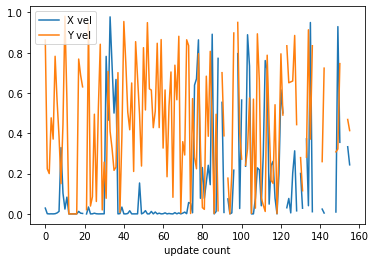

In [236]:
plt.plot((batch_pvalue_matrix_neuron[:,1:]))
plt.xlabel('update count')
plt.legend(['X vel', 'Y vel'])

AttributeError: 'numpy.ndarray' object has no attribute 'legend'

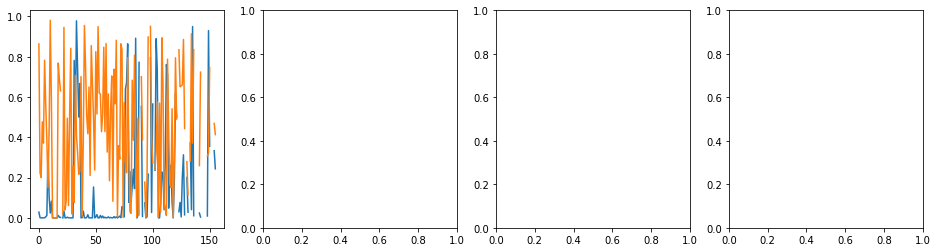

In [234]:
n_roi_neuron = 0


fig, axs = plt.subplots(1,N_NEURONS, figsize = (16,4))

for n in range(N_NEURONS):
    batch_pvalue_matrix_neuron = np.squeeze(batch_pvalue_matrix[:,n,:])
    axs[n].plot(batch_pvalue_matrix_neuron[:,1:])
    ('p value for X vel', 'p value for y vel')
    
